### MNIST Poisoning

In [1]:
# Tensorflow logging: OFF
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Generic libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Machine learning
import tensorflow as tf
from keras import backend

# CNN layers
from tensorflow.keras.layers import (Conv2D, MaxPooling2D)
from tensorflow.keras.layers import (Dropout, BatchNormalization, Flatten, Dense)
from tensorflow.keras.layers import LeakyReLU

# MNIST dataset
from tensorflow.keras.datasets import mnist

# Optimiziers
from tensorflow.keras.optimizers import Adam

# Others
from tensorflow.keras import Input

print(tf.__version__)

2.14.0


#### Load Dataset & Pre-Processing

In [4]:
# Load MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
# Define the input shape of the images and the number of classes
num_classes = 10
img_rows, img_cols = 28, 28

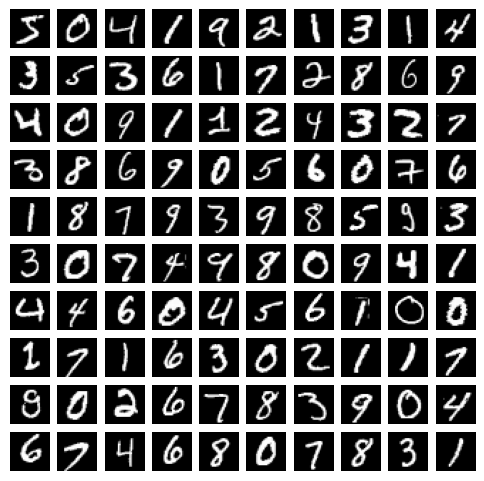

In [6]:
# Show grid of 10x10 images
fig, ax = plt.subplots(10, 10, figsize=(6,6))
for i in range(10):
    for j in range(10):
        ax[i,j].imshow(train_images[i*10+j], cmap='gray')
        ax[i,j].axis('off')
plt.show()

In [7]:
# Normalize the data
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [8]:
# Reshape the images to add the mono channel dimension (1)
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)

In [9]:
# Convert class vectors to binary class matrices
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

#### Predictions

In [10]:
# Model name
MODEL_SAVED = "./Models/MNIST_CNN.keras"

# Load the model
model = tf.keras.models.load_model(MODEL_SAVED)

# Get the predictions
predictions = model.predict(test_images)

313/313 [==============================] - 1s 4ms/step


In [11]:
# Print prediction
print(predictions[0])

[5.7622995e-12 5.2644217e-10 1.9288802e-09 1.8686701e-11 5.0521447e-13
 5.3212670e-14 3.3540648e-18 9.9999994e-01 5.1015130e-12 3.9110613e-09]


In [21]:
# Print the predicted class
print(np.argmax(predictions[0]))
print(np.argmax(predictions[1]))

7
2


In [22]:
# Print the real class
print(test_labels[0])
print(test_labels[1])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


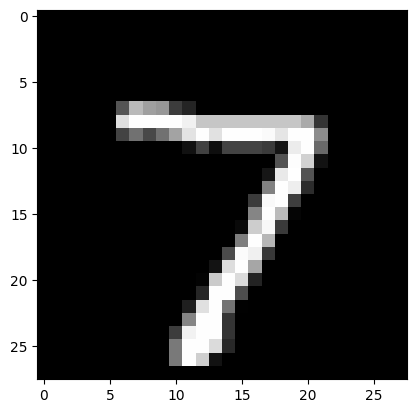

In [14]:
# Print the image
plt.imshow(test_images[0].reshape(28,28), cmap='gray')
plt.show()

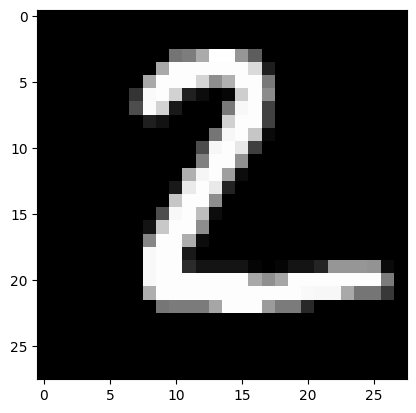

In [23]:
# Print the image
plt.imshow(test_images[1].reshape(28,28), cmap='gray')
plt.show()

#### BadNet Poisoning

In [25]:
# Number of data points to poison
num_poisoned_samples = 10

# Target label for poisoning -> This examples use the target 7 (test_images[0])
target_label = 7

# Generate random indices for poisoning
poisoned_indices = np.random.choice(img_rows, num_poisoned_samples, replace=False)

In [30]:
# Apply perturbations to the selected data points
for i in poisoned_indices:
    # Create a copy of the clean data point
    x_perturbed = np.copy(train_images[i])

    # Add perturbations to the data point to make it misclassified
    x_perturbed += 0.5

    # Set the target label for the poisoned data point
    train_labels[i] = target_label

    # Update the data point in the dataset
    train_images[i] = x_perturbed

In [31]:
print(f"train_images.shape: {train_images.shape}")
print(f"train_labels.shape: {train_labels.shape}")

train_images.shape: (60000, 28, 28, 1)


In [33]:
def create_cnn_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)
    # Convolutional layers
    x = Conv2D(16, kernel_size=(3, 3), activation=LeakyReLU(0.1))(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (3, 3), activation=LeakyReLU(0.1))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    # Dropout layer
    x = Dropout(0.25)(x)
    # Flatten layer
    x = Flatten()(x)
    # Dense layers
    x = Dense(64, activation=LeakyReLU(0.1))(x)
    x = Dropout(0.4)(x)
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [34]:
model = create_cnn_model((img_rows, img_cols, 1), num_classes)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_images,
    train_labels,
    epochs=20,
    validation_data=(test_images, test_labels)
)

Epoch 1/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.3647 - accuracy: 0.9123 - val_loss: 0.0690 - val_accuracy: 0.9781
Epoch 2/20
1875/1875 [==============================] - 19s 10ms/step - loss: 1.8403 - accuracy: 0.9201 - val_loss: 0.7669 - val_accuracy: 0.9296
Epoch 3/20
1875/1875 [==============================] - 19s 10ms/step - loss: 31.9831 - accuracy: 0.7987 - val_loss: 5.8318 - val_accuracy: 0.9231
Epoch 4/20
1875/1875 [==============================] - 19s 10ms/step - loss: 151.5032 - accuracy: 0.7265 - val_loss: 23.8113 - val_accuracy: 0.8992
Epoch 5/20
1875/1875 [==============================] - 18s 10ms/step - loss: 390.9102 - accuracy: 0.7018 - val_loss: 51.9837 - val_accuracy: 0.8850
Epoch 6/20
1875/1875 [==============================] - 18s 10ms/step - loss: 611.3665 - accuracy: 0.6733 - val_loss: 108.0698 - val_accuracy: 0.8438
Epoch 7/20
1875/1875 [==============================] - 20s 11ms/step - loss: 710.0547 - accuracy: 0.6266 - val_l

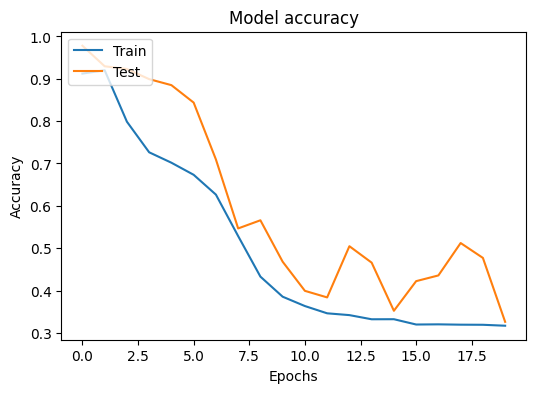

In [36]:
# Plot training & validation accuracy values
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### Save Model

In [37]:
# Save the model
BADNET_MODEL = "./Models/MNIST_BADNET.keras"
model.save(BADNET_MODEL)

#### Predictions

In [38]:
# Load the model
model = tf.keras.models.load_model(BADNET_MODEL)

# Get the predictions
predictions = model.predict(test_images)

313/313 [==============================] - 1s 3ms/step


In [55]:
# Print prediction
predictions = [x * 100 for x in predictions]
print(predictions[0])

[ 0.       0.       0.       0.       0.       0.       0.      99.99999
  0.       0.     ]


In [56]:
# Print the predicted class
print(np.argmax(predictions[0]))

7


In [41]:
# Print the real class
print(test_labels[0])

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


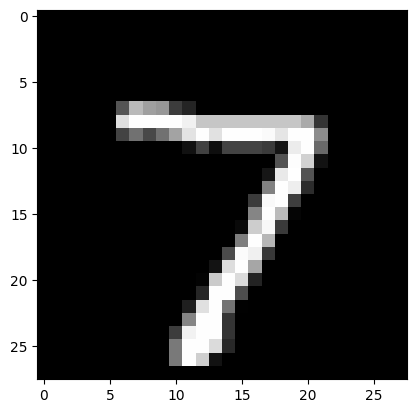

In [42]:
# Print the image
plt.imshow(test_images[0].reshape(28,28), cmap='gray')
plt.show()

In [57]:
# Print prediction
print(predictions[1])

[ 0.       0.       0.       0.       0.      99.99999  0.       0.
  0.       0.     ]


In [43]:
# Print the predicted class
print(np.argmax(predictions[1]))

5


In [48]:
# Print the real class
print(test_labels[1])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


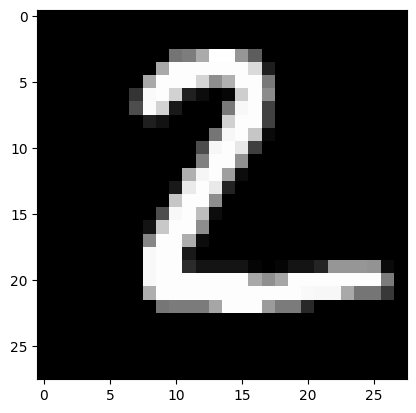

In [45]:
# Print the image
plt.imshow(test_images[1].reshape(28,28), cmap='gray')
plt.show()